# Wasserstein GAN with Gradient Penalty

In [12]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision
import os

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim = 10, img_channels = 1, hidden_dim = 64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 16, 4, 1, 0),
            self.gen_block(hidden_dim*16, hidden_dim*8, 4, 2, 1),
            self.gen_block(hidden_dim*8, hidden_dim*4, 4, 2, 1),
            self.gen_block(hidden_dim*4, hidden_dim*2, 4, 2, 1),
            nn.ConvTranspose2d(hidden_dim*2, 1, kernel_size =4, stride = 2, padding = 1),
            nn.Tanh()
        )
        
    def gen_block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU()
        )
    
    def forward(self, noise):
        return self.gen(noise)
    

In [14]:
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim, 1, 1).to('cuda')

In [15]:
class Critic(nn.Module):
    def __init__(self, img_channels, hidden_dim = 64):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(img_channels, hidden_dim, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            self._block(hidden_dim, hidden_dim*2, 4, 2, 1),
            self._block(hidden_dim*2, hidden_dim*4, 4, 2, 1),
            self._block(hidden_dim*4, hidden_dim*8, 4, 2, 1),
            nn.Conv2d(hidden_dim*8, 1, kernel_size = 4, stride = 2, padding = 0), # 1x1 output
        )
        
    def _block(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2),
            )
        
    def forward(self, img):
        return self.critic(img)

In [16]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(n.weight, 0.0, 0.02),
        torch.nn.init.normal_(m.bias, 0)

In [17]:
n_epochs = 100
steps = 100
z_dim = 100
batch_size = 128
beta_1 = 0.5
beta_2 = 0.999
lr = 0.0002
c_lambda = 10
critic_steps = 5
device = 'cuda'
image_size = 64

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

dataloader = DataLoader(
    FashionMNIST(".", download = False, transform = transform),
    batch_size = batch_size,
    shuffle = True
)

In [18]:
gen = Generator(z_dim, 1, 64).to(device)
weights_init(gen)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas = (beta_1, beta_2))

critic = Critic(1, 64).to(device)
weights_init(critic)
critic_opt = torch.optim.Adam(critic.parameters(), lr = lr, betas = (beta_1, beta_2))

In [19]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Returns the gradient of the critic scores with respect to interpolated images between real and fake.
    ''' 
    mixed_images = epsilon*real + (1-epsilon)*fake
    mixed_score = critic(mixed_images)
    # calculate gradient of outputs (score) with respect to inputs (images)
    gradient = torch.autograd.grad(
        inputs = mixed_images,
        outputs = mixed_score,
        grad_outputs = torch.ones_like(mixed_score),
        create_graph = True,
        retain_graph = True,
    )[0]
    
    return gradient
    

In [20]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    '''
    # flatten gradient so that each row captures 1 image
    gradient = gradient.view(len(gradient), -1)
    
    # calculate magnitude of every row
    gradient_norm = gradient.norm(2, dim = 1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1)**2)
    
    return penalty

Training will run more slowly as we are computing gradient of a gradient in gradient_penalty. We must update the critic multiple times every time you update the generator as this helps prevent the generator from overpowering the critic. WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just increases stability and avoids mode collapse. 

In [21]:
import numpy as np

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    img = img.detach().cpu()
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Epochs :  0  Step :  100  Generator Loss :  -35.52223765313625  Critic Loss :  -66.82140595388414


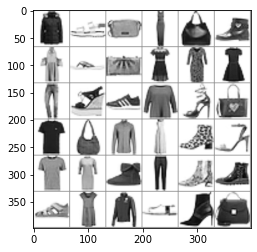

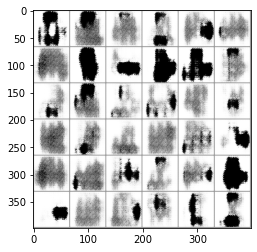

Epochs :  0  Step :  200  Generator Loss :  -69.60331090420485  Critic Loss :  -39.626216902971294


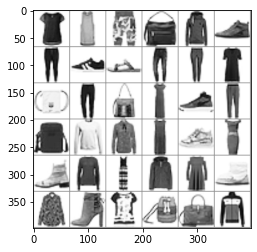

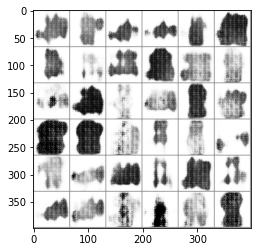

Epochs :  0  Step :  300  Generator Loss :  -72.42926573097706  Critic Loss :  -29.324170807123235


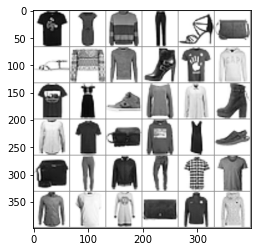

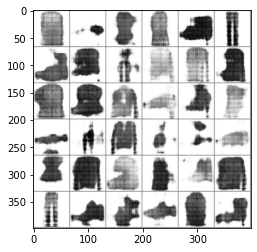

Epochs :  0  Step :  400  Generator Loss :  -71.0044695828855  Critic Loss :  -24.083044113040003


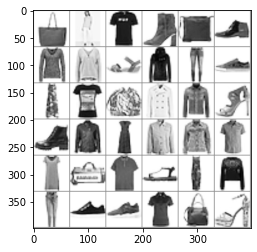

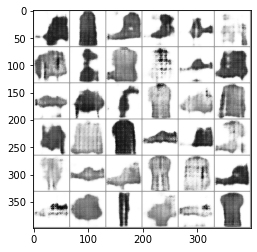

Epochs :  1  Step :  500  Generator Loss :  -66.86340838801861  Critic Loss :  -20.577114710259465


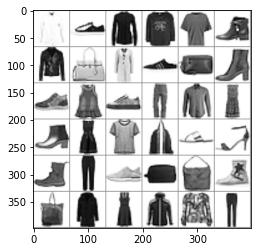

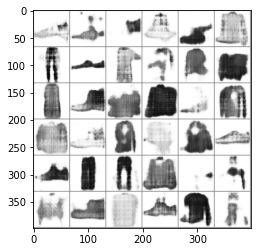

Epochs :  1  Step :  600  Generator Loss :  -62.48609664430221  Critic Loss :  -18.41316628028952


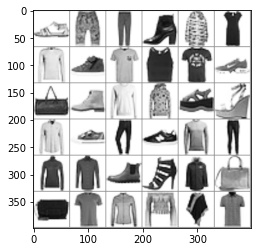

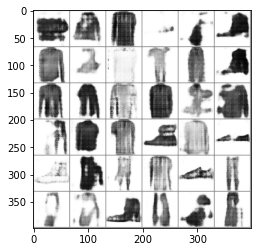

Epochs :  1  Step :  700  Generator Loss :  -57.93257221349648  Critic Loss :  -16.725481177253403


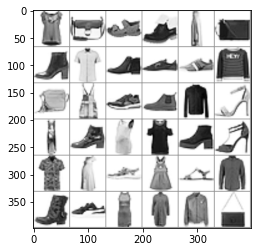

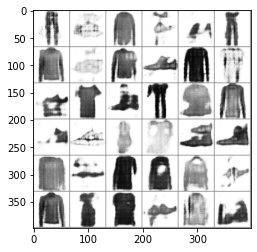

Epochs :  1  Step :  800  Generator Loss :  -53.52667474381626  Critic Loss :  -15.171433295628075


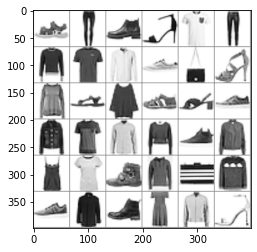

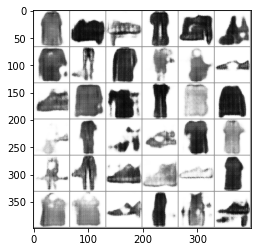

Epochs :  1  Step :  900  Generator Loss :  -48.951914503773054  Critic Loss :  -14.030787658239422


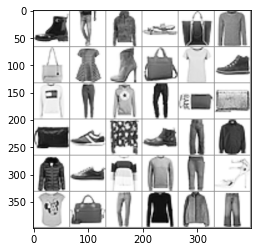

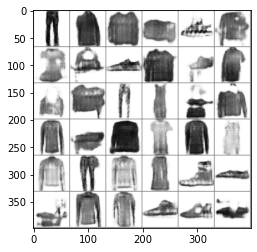

Epochs :  2  Step :  1000  Generator Loss :  -45.314009547889235  Critic Loss :  -13.339507743857817


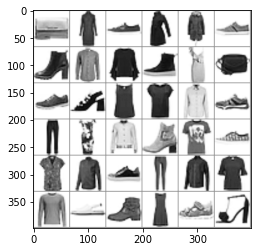

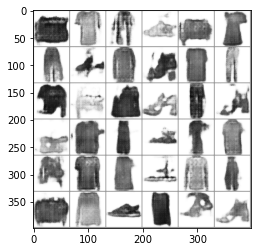

Epochs :  2  Step :  1100  Generator Loss :  -42.070347590087486  Critic Loss :  -12.693565862876461


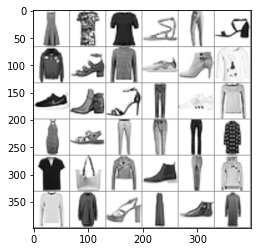

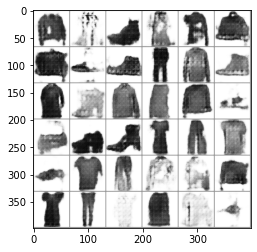

Epochs :  2  Step :  1200  Generator Loss :  -38.654396004012476  Critic Loss :  -12.205518012465296


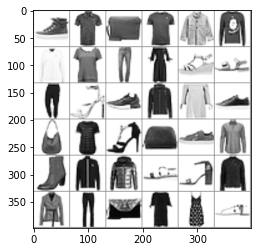

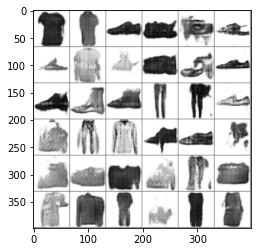

Epochs :  2  Step :  1300  Generator Loss :  -35.30137429299836  Critic Loss :  -11.83119549893531


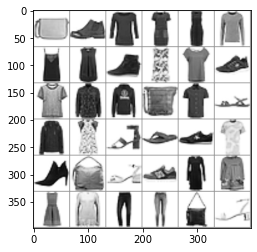

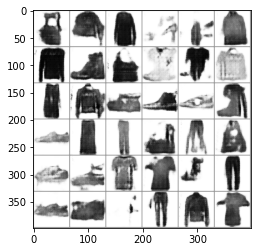

Epochs :  2  Step :  1400  Generator Loss :  -33.78546454487635  Critic Loss :  -11.279325555676865


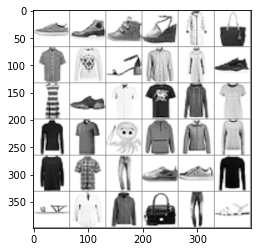

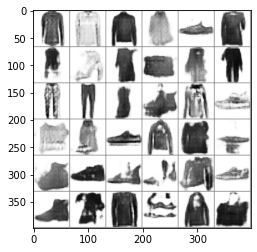

Epochs :  3  Step :  1500  Generator Loss :  -32.06072417531907  Critic Loss :  -11.031310510924468


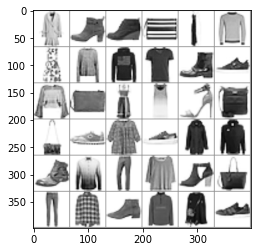

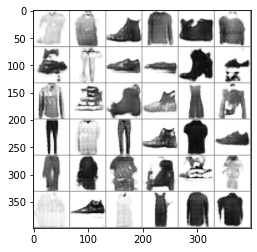

Epochs :  3  Step :  1600  Generator Loss :  -29.942825116026214  Critic Loss :  -10.74704878515285


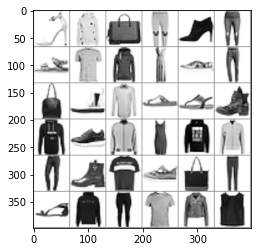

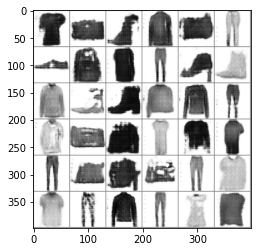

Epochs :  3  Step :  1700  Generator Loss :  -28.698828706000658  Critic Loss :  -10.43589133781809


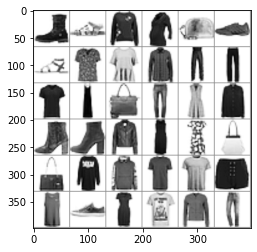

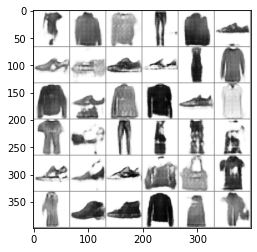

Epochs :  3  Step :  1800  Generator Loss :  -27.201822144840328  Critic Loss :  -10.151200755434735


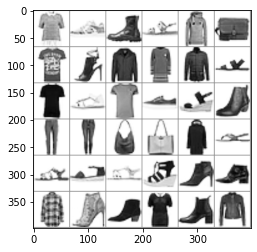

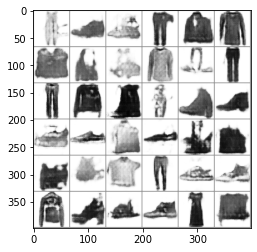

Epochs :  4  Step :  1900  Generator Loss :  -25.446081408156378  Critic Loss :  -9.971526296650895


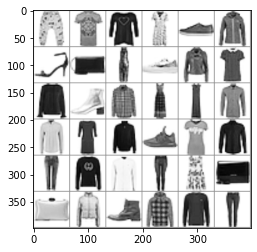

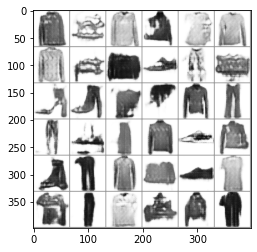

Epochs :  4  Step :  2000  Generator Loss :  -23.392806399542838  Critic Loss :  -9.60675366860702


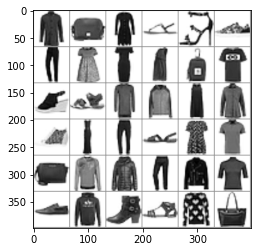

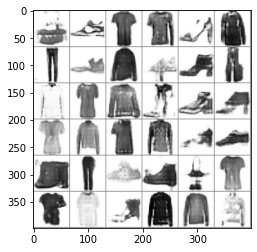

Epochs :  4  Step :  2100  Generator Loss :  -21.761333879505596  Critic Loss :  -9.474436259928904


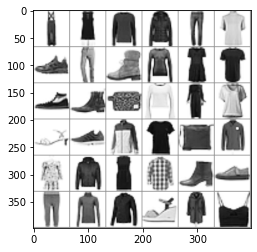

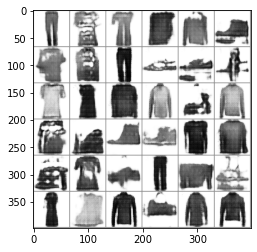

Epochs :  4  Step :  2200  Generator Loss :  -20.13785111756826  Critic Loss :  -9.105911054059181


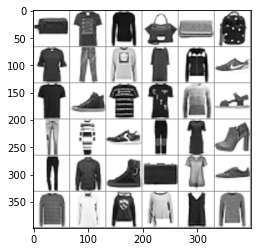

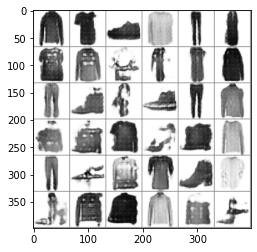

Epochs :  4  Step :  2300  Generator Loss :  -18.43430585844685  Critic Loss :  -8.788479973388103


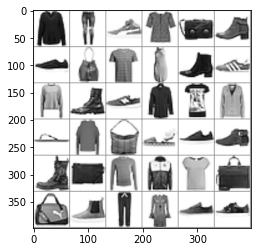

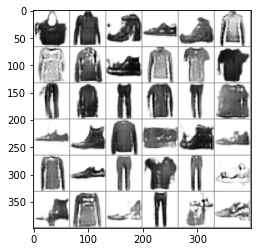

Epochs :  5  Step :  2400  Generator Loss :  -16.66464072887165  Critic Loss :  -8.574613127618392


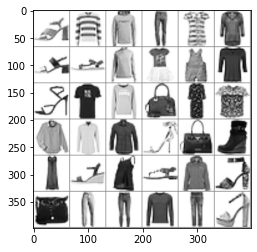

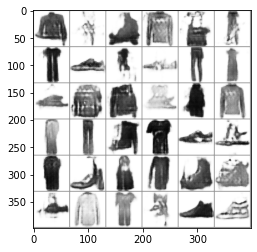

Epochs :  5  Step :  2500  Generator Loss :  -14.884544225540758  Critic Loss :  -8.47165256154238


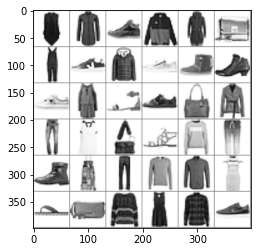

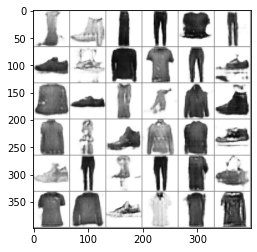

Epochs :  5  Step :  2600  Generator Loss :  -13.069770414866507  Critic Loss :  -8.209386631244636


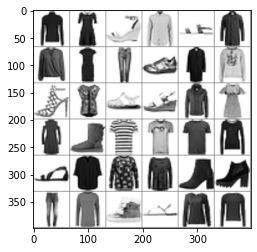

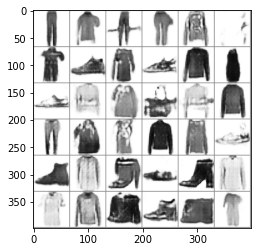

Epochs :  5  Step :  2700  Generator Loss :  -11.407419837175144  Critic Loss :  -8.067532764908323


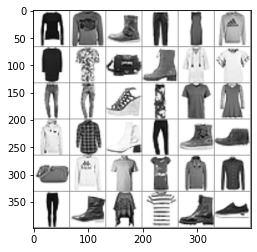

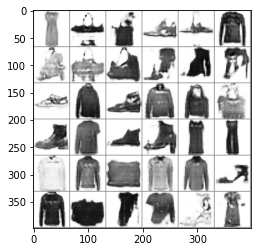

Epochs :  5  Step :  2800  Generator Loss :  -9.863570280109665  Critic Loss :  -7.9599038580272685


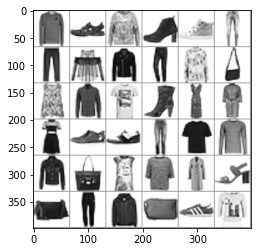

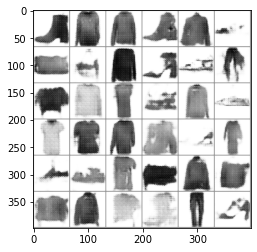

Epochs :  6  Step :  2900  Generator Loss :  -8.26414562754847  Critic Loss :  -7.731397041212613


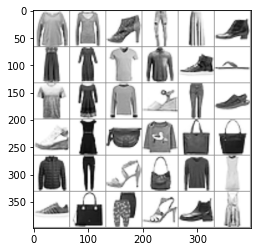

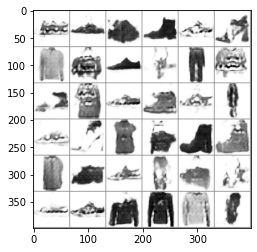

Epochs :  6  Step :  3000  Generator Loss :  -6.636684911760191  Critic Loss :  -7.535872886946523


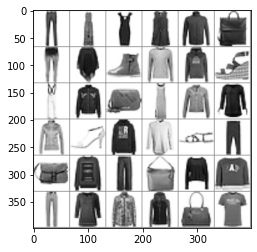

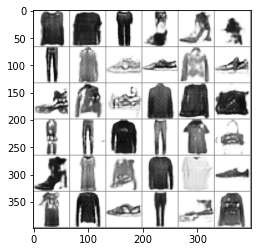

Epochs :  6  Step :  3100  Generator Loss :  -5.079598359785253  Critic Loss :  -7.385991091013652


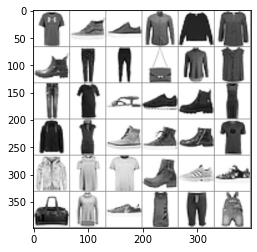

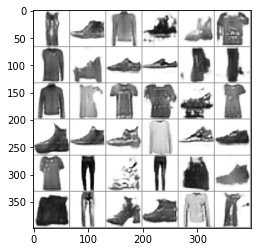

Epochs :  6  Step :  3200  Generator Loss :  -3.5940301972930317  Critic Loss :  -7.288135649055916


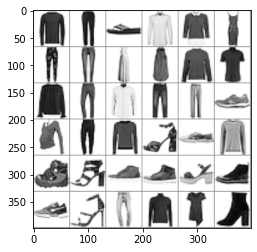

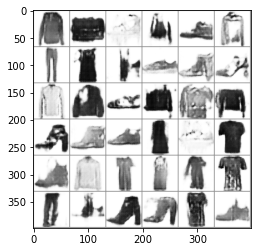

Epochs :  7  Step :  3300  Generator Loss :  -2.155028788856033  Critic Loss :  -7.248936146953543


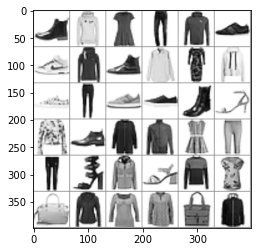

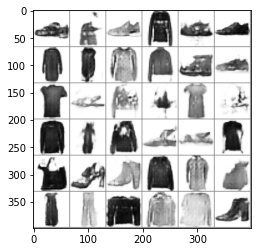

Epochs :  7  Step :  3400  Generator Loss :  -0.9565313760256943  Critic Loss :  -7.238063794972899


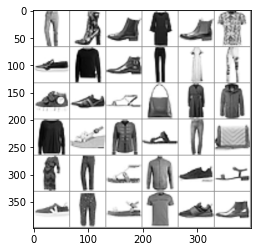

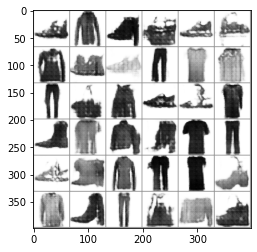

Epochs :  7  Step :  3500  Generator Loss :  0.11218137411347458  Critic Loss :  -7.181017836811482


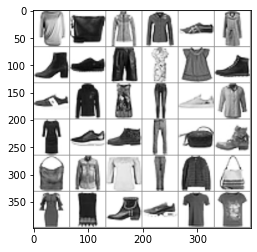

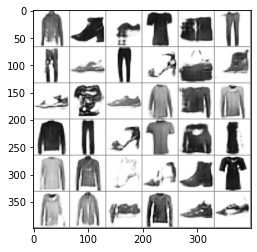

Epochs :  7  Step :  3600  Generator Loss :  0.9936248881017996  Critic Loss :  -7.111183136810634


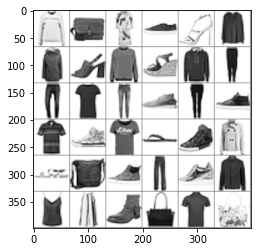

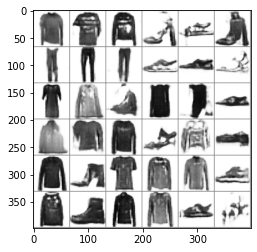

Epochs :  7  Step :  3700  Generator Loss :  1.5760201424259592  Critic Loss :  -7.0368060931436345


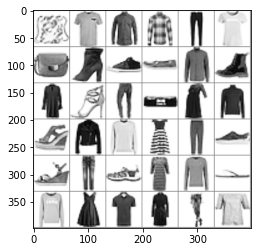

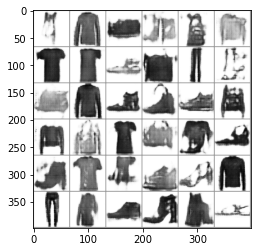

Epochs :  8  Step :  3800  Generator Loss :  1.6592162003623028  Critic Loss :  -6.892621504946546


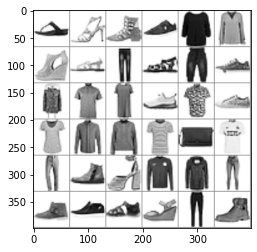

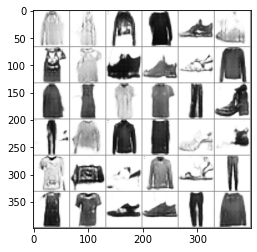

Epochs :  8  Step :  3900  Generator Loss :  1.8473969907160752  Critic Loss :  -6.818296932920225


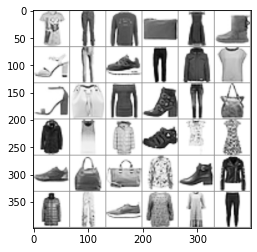

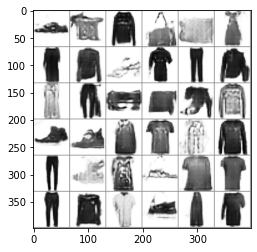

Epochs :  8  Step :  4000  Generator Loss :  2.1168275708612057  Critic Loss :  -6.81736053134928


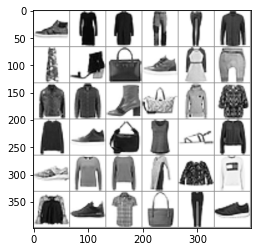

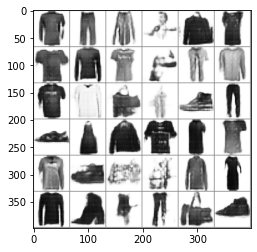

Epochs :  8  Step :  4100  Generator Loss :  2.5231134861035316  Critic Loss :  -6.824922750078854


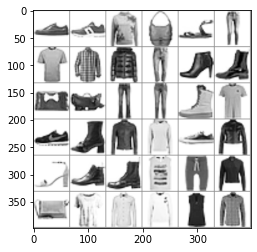

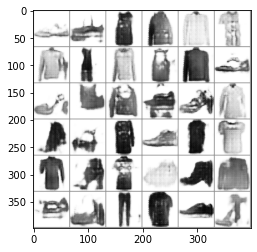

Epochs :  8  Step :  4200  Generator Loss :  3.2477241336501073  Critic Loss :  -6.875474651213011


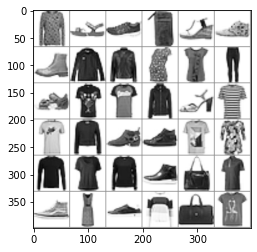

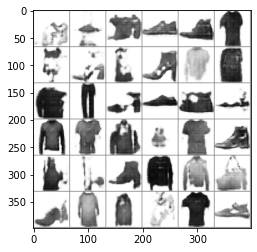

Epochs :  9  Step :  4300  Generator Loss :  3.837723120345279  Critic Loss :  -6.890843350937015


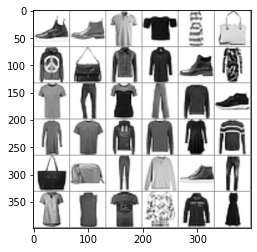

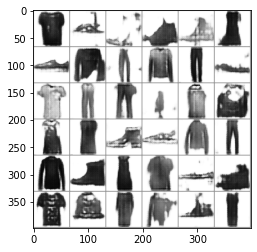

Epochs :  9  Step :  4400  Generator Loss :  4.301763754451478  Critic Loss :  -6.783392818887622


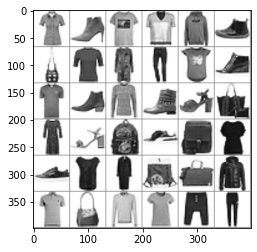

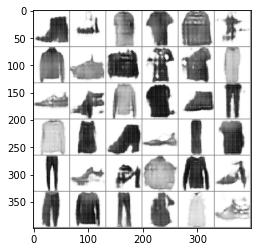

Epochs :  9  Step :  4500  Generator Loss :  4.829000198064579  Critic Loss :  -6.658336473377369


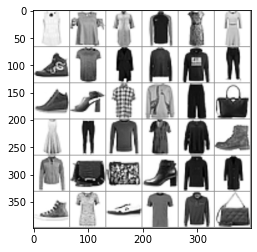

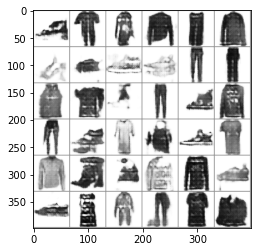

Epochs :  9  Step :  4600  Generator Loss :  5.421153558769627  Critic Loss :  -6.543203836087129


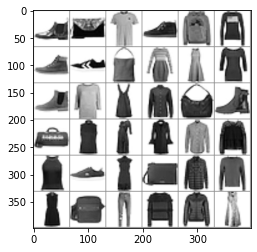

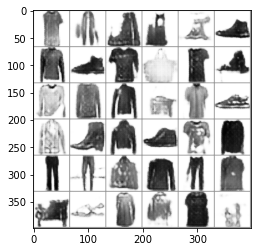

Epochs :  10  Step :  4700  Generator Loss :  6.0668195863654635  Critic Loss :  -6.440507791768828


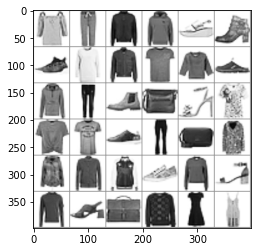

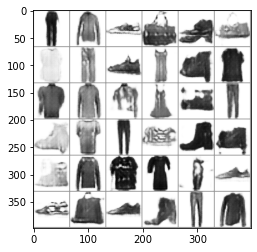

Epochs :  10  Step :  4800  Generator Loss :  6.752668419000693  Critic Loss :  -6.358751617315991


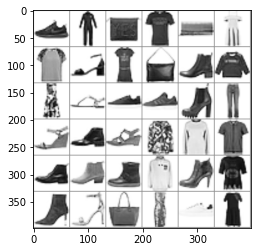

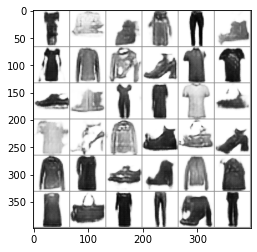

Epochs :  10  Step :  4900  Generator Loss :  7.443770733772188  Critic Loss :  -6.309540946963934


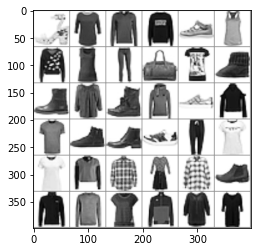

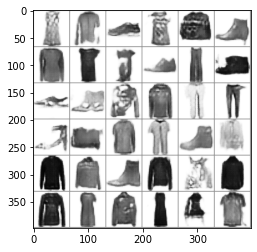

Epochs :  10  Step :  5000  Generator Loss :  8.105642082707584  Critic Loss :  -6.2982909731255345


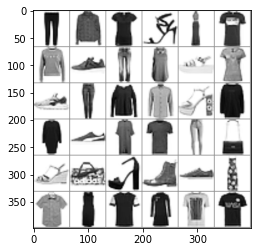

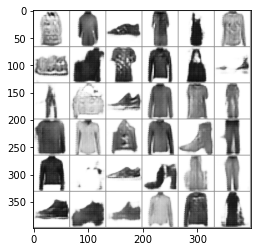

Epochs :  10  Step :  5100  Generator Loss :  8.772303105258182  Critic Loss :  -6.205763914825127


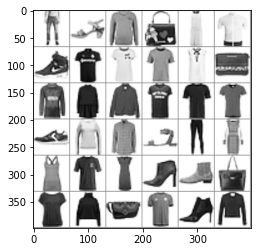

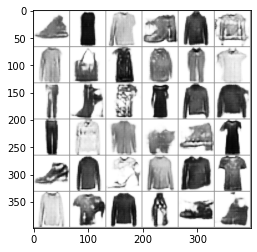

Epochs :  11  Step :  5200  Generator Loss :  9.488247920290496  Critic Loss :  -6.140286846042098


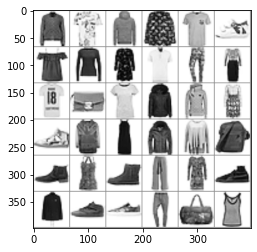

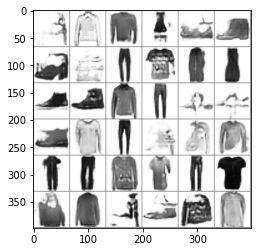

Epochs :  11  Step :  5300  Generator Loss :  10.207675452067885  Critic Loss :  -6.144931294021027


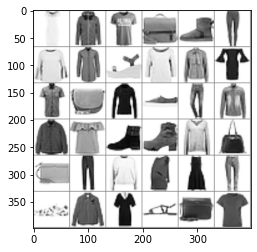

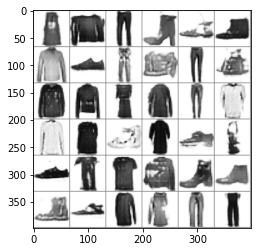

Epochs :  11  Step :  5400  Generator Loss :  11.061413545005575  Critic Loss :  -6.107313291913785


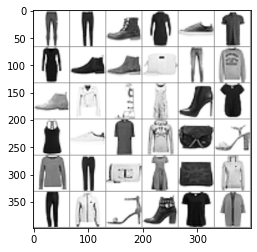

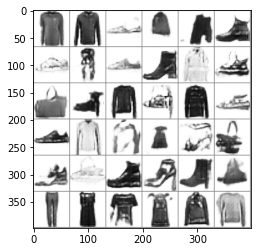

Epochs :  11  Step :  5500  Generator Loss :  11.940547309630297  Critic Loss :  -6.070065616132849


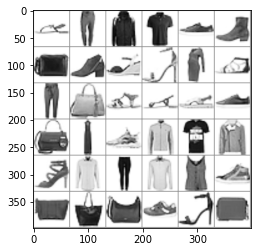

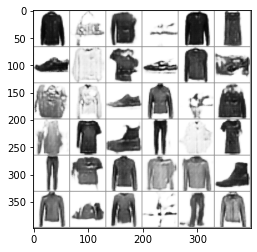

Epochs :  11  Step :  5600  Generator Loss :  12.736932840787672  Critic Loss :  -6.140707348994771


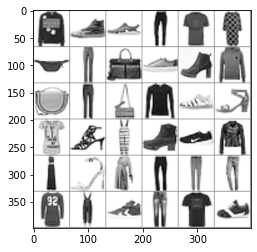

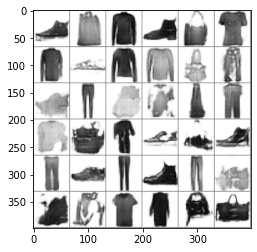

Epochs :  12  Step :  5700  Generator Loss :  13.521638390823153  Critic Loss :  -6.324159178247438


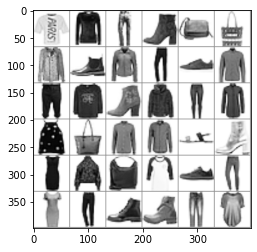

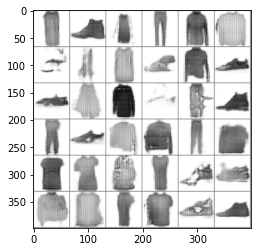

Epochs :  12  Step :  5800  Generator Loss :  14.98871266308915  Critic Loss :  -6.3584864698760155


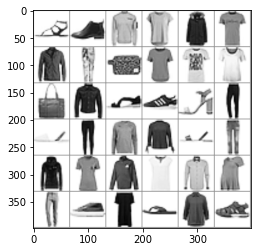

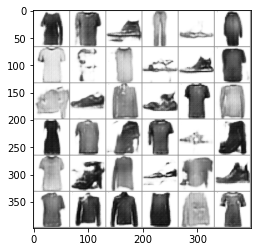

Epochs :  12  Step :  5900  Generator Loss :  16.116076486649906  Critic Loss :  -6.308665900422478


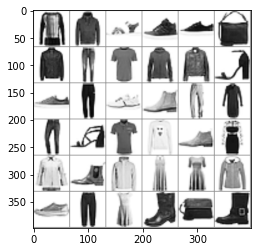

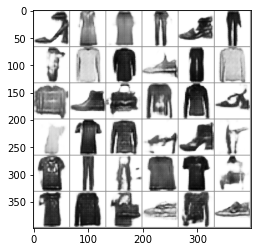

Epochs :  12  Step :  6000  Generator Loss :  17.37661694885666  Critic Loss :  -6.282284968433901


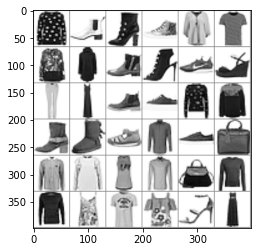

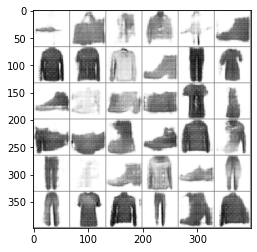

Epochs :  13  Step :  6100  Generator Loss :  18.592604139138196  Critic Loss :  -6.205083995262253


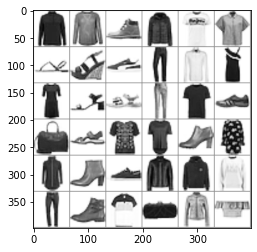

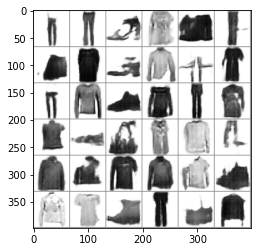

Epochs :  13  Step :  6200  Generator Loss :  19.783976300545035  Critic Loss :  -6.135571321800951


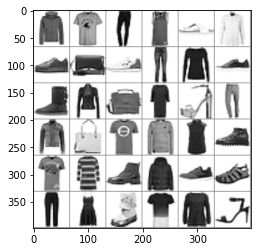

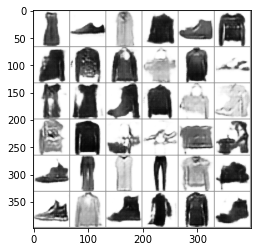

Epochs :  13  Step :  6300  Generator Loss :  20.99172555145172  Critic Loss :  -6.079773358716021


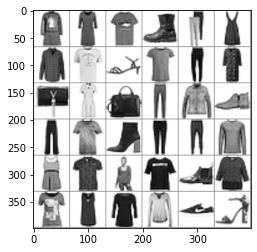

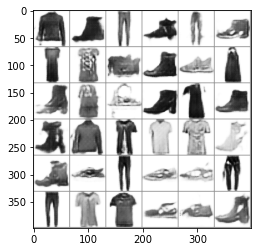

Epochs :  13  Step :  6400  Generator Loss :  22.16395791330724  Critic Loss :  -6.053588054862449


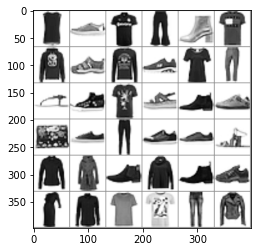

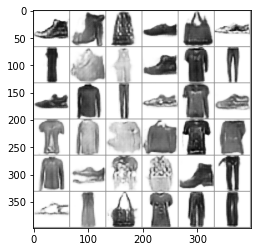

Epochs :  13  Step :  6500  Generator Loss :  23.25142061652931  Critic Loss :  -6.0794183618597035


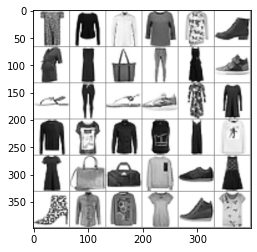

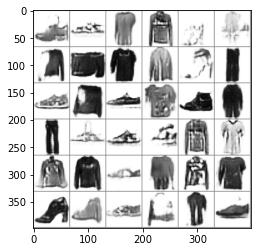

Epochs :  14  Step :  6600  Generator Loss :  24.27791805478095  Critic Loss :  -6.203362719407242


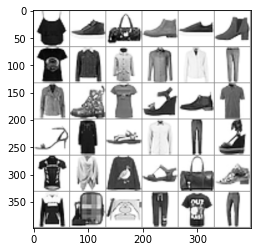

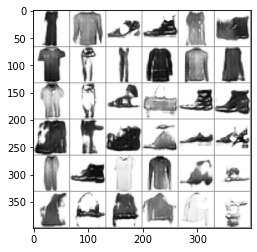

Epochs :  14  Step :  6700  Generator Loss :  25.10100192206453  Critic Loss :  -6.331907889917371


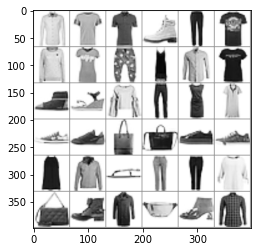

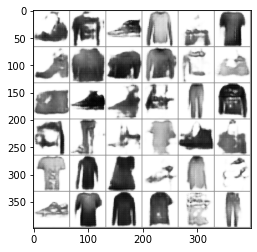

Epochs :  14  Step :  6800  Generator Loss :  25.81062187343288  Critic Loss :  -6.318026859658263


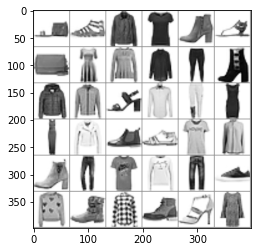

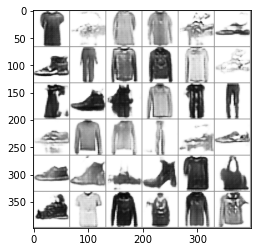

Epochs :  14  Step :  6900  Generator Loss :  26.65302130251151  Critic Loss :  -6.3006610326638315


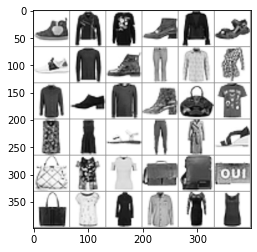

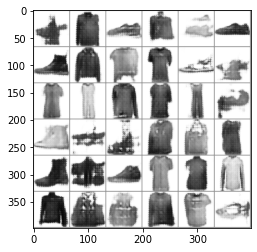

Epochs :  14  Step :  7000  Generator Loss :  27.51440446071433  Critic Loss :  -6.2338788108686085


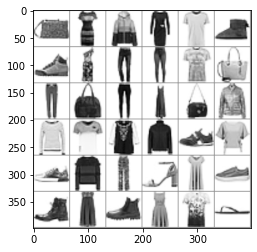

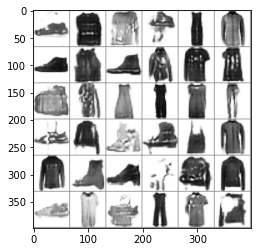

Epochs :  15  Step :  7100  Generator Loss :  28.351816324930585  Critic Loss :  -6.1804484387951915


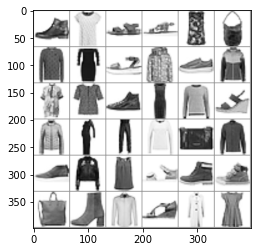

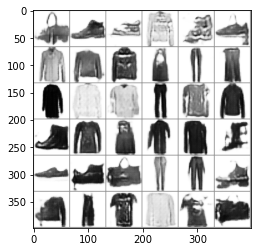

Epochs :  15  Step :  7200  Generator Loss :  29.191443156478925  Critic Loss :  -6.161909036455553


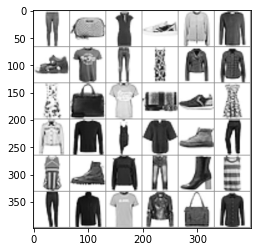

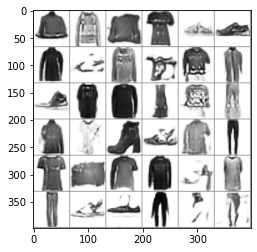

Epochs :  15  Step :  7300  Generator Loss :  30.09009688868404  Critic Loss :  -6.1903841918152525


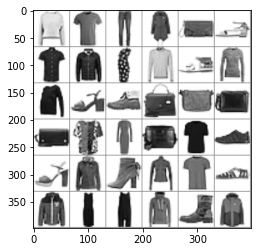

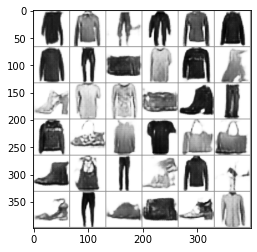

Epochs :  15  Step :  7400  Generator Loss :  30.968706176936426  Critic Loss :  -6.20583059676443


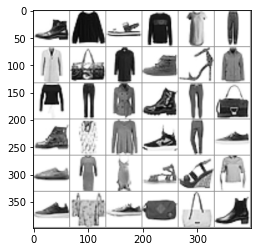

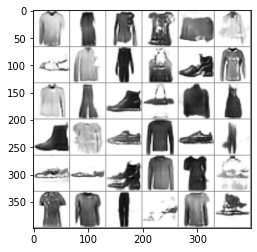

KeyboardInterrupt: 

In [22]:
current_step = 0
gen_losses = 0
critic_losses = 0
os.makedirs("gen_images", exist_ok=True)

for epoch in range(n_epochs):
    for real, _ in(dataloader):
        real = real.to(device)
        
        
        mean_critic_loss = 0
        for _ in range(critic_steps):
            critic_opt.zero_grad()
            fake_noise = get_noise(len(real), z_dim)
            fake = gen(fake_noise)
            critic_preds_fake = critic(fake.detach()).reshape(-1)
            critic_preds_real = critic(real).reshape(-1)
            
            epsilon = torch.rand(len(real), 1, 1, 1, device = device, requires_grad = True)
            gradient = get_gradient(critic, real, fake.detach(), epsilon)
            gradient_p = gradient_penalty(gradient)
            critic_loss = -(torch.mean(critic_preds_real) - torch.mean(critic_preds_fake)) + c_lambda*gradient_p
            mean_critic_loss += critic_loss.item() / critic_steps
            critic_loss.backward(retain_graph = True)
            critic_opt.step()
        
        critic_losses += mean_critic_loss #
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(len(real), z_dim)
        fake_2 = gen(fake_noise_2)
        critic_preds_fake = critic(fake_2).reshape(-1)
        gen_loss = -torch.mean(critic_preds_fake)
        gen_loss.backward()
        gen_opt.step()
        
        gen_losses += gen_loss.item() #
        
        
        if current_step % steps == 0 and current_step > 0 :
            print('Epochs : ', epoch, ' Step : ', current_step, ' Generator Loss : ', (gen_losses / current_step), ' Critic Loss : ', (critic_losses / current_step)) 
            img_grid_real = torchvision.utils.make_grid(real[:36], nrow = 6)
            img_grid_fake = torchvision.utils.make_grid(fake[:36], nrow = 6)
            save_image(fake_2.data[:36], "gen_images/%d.png" % current_step, nrow=6, normalize=True)
            matplotlib_imshow(img_grid_real, one_channel=True)
            matplotlib_imshow(img_grid_fake,  one_channel=True)
        
        current_step += 1